<h1><center>Darwin Supervised Regression Model Building </center></h1>

First, 
<br>if you have just received a new api key from support, you will need to register your key and create a new user (see Register user cell)

Second, in the Environment Variables cell: 
1. Set your username and password to ensure that you're able to log in successfully
2. Set the path to the location of your datasets if you are using your own data.  The path is set for the examples.
3. Set the dataset names accordingly

Here are a few things to be mindful of:
1. For every run, check the job status (i.e. requested, failed, running, completed) and wait for job to complete before proceeding. 
2. If you're not satisfied with your model and think that Darwin can benefit from extra training, use the resume function.

### Set Darwin SDK

In [1]:
from amb_sdk.sdk import DarwinSdk
ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/');

### Environment Variables

In [2]:
#Set your user id and password accordingly
USER="justin.kang23@gmail.com"
PW="psjf52vRYb"

# Set path to datasets - The default below assumes Jupyter was started from amb-sdk/examples/Enterprise/
# Modify accordingly if you wish to use your own data
PATH_TO_DATASET='data/'
DATASET_NAME='data.csv'

# A timestamp is used to create a unique name in the event you execute the workflow multiple times or with 
# different datasets.  File names must be unique in Darwin.
import datetime
ts = '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now())

### Import necessary libraries

In [3]:
# Import necessary libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
from time import sleep
import os
import numpy as np
from sklearn.metrics import r2_score
from scipy import stats

### User Login 

In [4]:
status, msg = ds.auth_login_user(USER,PW)
if not status:
    print(msg)

### Data Upload

**Feature engineering and adding labels**

In [5]:
def calculate_adults(row):
    return 100-row['% Age 65 and Older']-row['% Age 17 and Under']

In [142]:
def strip_extra_chars(row, column, char):
    if row[column] == 'N/A**':
        return np.nan
    new_val = float(row[column].strip(char).replace(",", ""))
    if char == "%":
        return new_val / 100.0 #have to divide by 100 for percents
    return new_val

In [6]:
def drop_features(df):
    with open('data/remove_col_names.txt', 'r') as f:
        drop_cols=f.read().splitlines()
    return df.drop(columns=drop_cols)

In [250]:
# Preview dataset
df = pd.read_csv(os.path.join(PATH_TO_DATASET, 'exemptions.csv'))
df.drop(df.tail(1).index,inplace=True)

#Collect all possible data and combine into a single dataframe
for file in os.listdir(PATH_TO_DATASET):
    if 'csv' in file and 'exemptions' not in file: #dont add exemptions twice
        df2=pd.read_csv(os.path.join(PATH_TO_DATASET, file))
        df=df.merge(df2, on='County')

#Feature engineering - create "% Adults" feature from other age features
df['% Age 18-65']=df.apply (lambda row: calculate_adults(row), axis=1)

#Feature selection - remove features that were likely to have no effect 
df=drop_features(df)

#Data cleaning - remove extranous characters and convert strings to floats
for i in range(1, 9):
    df.iloc[:,i]=df.apply( lambda row: strip_extra_chars(row, i, "%"), axis=1)

strip_dollar = ['Total County Tax Rate', 'Per Capita Income']
for category in strip_dollar:
    df[category]=df.apply( lambda row: strip_extra_chars(row, category, "$"), axis=1)

labeled_df = df.copy(deep=True)

#More feature selection - Drop non-sociodemographic features
for i in range(1, 8):
    labeled_df = labeled_df.drop(labeled_df.columns[1], axis=1)
labeled_df.to_csv('pruned_data.csv', index=False)
labeled_df.head()


,County,2017-2018,Median Age,% Age 17 and Under,% High School Graduate or Higher,% Bachelor s Degree or Higher,Unemployment Rate (%),Ethnicity: % Hispanic,Race: % White Alone,Race: % African American Alone,Race: % Asian Alone,Total County Tax Rate,Percent Urban,Per Capita Income,Population Density Per Sq Mile,% Age 18-65
0,Anderson,0.0075,39.1,19.58,80.2,11.8,3.6,17.82,75.11,21.49,0.90,0.590892,32.94,33362.0,55.01,65.88
1,Andrews,0.0107,31.8,30.90,73.8,10.6,3.1,56.19,94.22,1.94,0.75,0.600700,83.50,43105.0,9.85,58.57
2,Angelina,0.0067,37.1,25.81,79.9,15.7,5.1,22.18,81.27,15.44,1.17,0.458800,56.92,37555.0,108.77,58.40
3,Aransas,0.0149,49.3,18.73,83.2,20.2,6.8,27.66,93.05,1.79,1.93,0.403315,72.74,44820.0,91.87,53.97
4,Archer,0.0081,44.3,21.77,90.1,21.8,3.4,8.68,95.58,1.03,0.43,0.675030,11.01,47110.0,10.03,58.34


In [251]:
#Select 80% of data set to train the model
start =int(labeled_df.shape[0]/5)
training_set = labeled_df.iloc[start:, :]
training_set.to_csv('training_data.csv', index=False)
training_set.head()

,County,2017-2018,Median Age,% Age 17 and Under,% High School Graduate or Higher,% Bachelor s Degree or Higher,Unemployment Rate (%),Ethnicity: % Hispanic,Race: % White Alone,Race: % African American Alone,Race: % Asian Alone,Total County Tax Rate,Percent Urban,Per Capita Income,Population Density Per Sq Mile,% Age 18-65
49,Coryell,0.0101,32.1,23.12,87.6,15.1,4.3,18.29,73.76,17.49,2.14,0.49366,80.58,32904.0,71.66,66.86
50,Cottle,0.0000,46.1,22.57,72.2,16.2,4.3,24.44,87.45,9.66,0.07,0.77870,0.00,60247.0,1.67,52.70
51,Crane,0.0037,33.5,29.96,72.8,12.9,5.3,63.31,91.98,3.80,0.89,0.78000,89.30,39596.0,5.57,58.14
52,Crockett,0.0042,40.0,25.42,73.7,11.0,4.1,65.68,94.00,1.66,0.87,0.95231,77.25,36757.0,1.32,57.52
53,Crosby,0.0102,37.5,26.94,72.3,12.1,4.1,56.28,93.02,3.87,0.22,0.63000,0.00,34530.0,6.73,54.96


**Upload dataset to Darwin**

In [252]:
#Clear existing dataset in database
ds.delete_dataset("training_data.csv")

(True, None)

In [253]:
# Upload dataset to Darwin
status, dataset = ds.upload_dataset(os.path.join("./", 'training_data.csv'))
if not status:
    print(dataset)

**Clean Dataset**

In [254]:
# Clean datset using ffill for non-present values
target = "2017-2018"
status, job_id = ds.clean_data('training_data.csv', impute='ffill', target = target)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-20T19:34:48.502328', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['training_data.csv'], 'artifact_names': ['69ec97bf84364da592f2803f34498be6'], 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-20T19:34:48.502328', 'endtime': '2019-04-20T19:34:50.906729', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['training_data.csv'], 'artifact_names': ['69ec97bf84364da592f2803f34498be6'], 'model_name': None, 'job_error': ''}


### Create and Train Model

We will now build a model that will learn the class labels in the target column.
In the default boston dataset, the target column is "Assessed_Value". 
You will have to specify your own target name for your custom dataset. 
You can also increase max_train_time for longer training.

In [256]:
#Create and train model
model = "Labels" + "_model8_" + ts
status, job_id = ds.create_model(dataset_names = "training_data.csv", \
                                 model_name =  model, \
                                 max_train_time = '00:02')
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Taken', 'starttime': '2019-04-20T19:35:15.866111', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['training_data.csv'], 'artifact_names': None, 'model_name': 'Labels_model8_20190420165230', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-20T19:35:15.866111', 'endtime': None, 'percent_complete': 3, 'job_type': 'TrainModel', 'loss': 0.4183467924594879, 'generations': 5, 'dataset_names': ['training_data.csv'], 'artifact_names': None, 'model_name': 'Labels_model8_20190420165230', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T19:35:15.866111', 'endtime': None, 'percent_complete': 15, 'job_type': 'TrainModel', 'loss': 0.35092800855636597, 'generations': 5, 'dataset_names': ['training_data.csv'], 'artifact_names': None, 'model_name': 'Labels_model8_20190420165230', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T19:35:15.866111', 'endtime': '2019-04-20T19:35:56.54

In [257]:
# Train some more
status, job_id = ds.resume_training_model(dataset_names = "training_data.csv",
                                          model_name = model,
                                          max_train_time = '00:05')
                                          
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-20T19:36:08.865284', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.35092800855636597, 'generations': 5, 'dataset_names': ['training_data.csv'], 'artifact_names': None, 'model_name': 'Labels_model8_20190420165230', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-20T19:36:08.865284', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.35092800855636597, 'generations': 8, 'dataset_names': ['training_data.csv'], 'artifact_names': None, 'model_name': 'Labels_model8_20190420165230', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T19:36:08.865284', 'endtime': None, 'percent_complete': 6, 'job_type': 'UpdateModel', 'loss': 0.3387911915779114, 'generations': 8, 'dataset_names': ['training_data.csv'], 'artifact_names': None, 'model_name': 'Labels_model8_20190420165230', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T19:36:08.865284', 'endtime': '2

### Analyze Data
**Analyze model provides feature importance ranked by the model. 
It indicates a general view of which features pose a bigger impact on the model**

In [258]:
# Retrieve feature importance of built model
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Running', 'starttime': '2019-04-20T19:37:11.184365', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.3387911915779114, 'generations': 8, 'dataset_names': None, 'artifact_names': ['a96ca75e3e9d4f4a81179d20e3f7e363'], 'model_name': 'Labels_model8_20190420165230', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T19:37:11.184365', 'endtime': '2019-04-20T19:37:14.469233', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.3387911915779114, 'generations': 8, 'dataset_names': None, 'artifact_names': ['a96ca75e3e9d4f4a81179d20e3f7e363'], 'model_name': 'Labels_model8_20190420165230', 'job_error': ''}


In [259]:
#Top 10 most important features
feature_importance[:10]

Unemployment Rate (%)               0.405357
% Bachelor s Degree or Higher       0.373715
Per Capita Income                   0.082817
Ethnicity: % Hispanic               0.020497
% Age 18-65                         0.016874
% High School Graduate or Higher    0.014746
Race: % White Alone                 0.013880
Total County Tax Rate               0.013560
Race: % African American Alone      0.011784
% Age 17 and Under                  0.010267
dtype: float64

In [260]:
#Least important features
feature_importance[10:]

Percent Urban                      0.009973
Median Age                         0.009482
Race: % Asian Alone                0.008569
 Population Density Per Sq Mile    0.008481
dtype: float64

### Predictions
**Perform model prediction on the the training dataset.**

In [261]:
#Run model on training data
status, artifact = ds.run_model("training_data.csv", model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Running', 'starttime': '2019-04-20T19:38:06.049222', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.3387911915779114, 'generations': 8, 'dataset_names': ['training_data.csv'], 'artifact_names': ['5d28a44bd65747c784ffd500b8db30e6'], 'model_name': 'Labels_model8_20190420165230', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T19:38:06.049222', 'endtime': '2019-04-20T19:38:14.183884', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.3387911915779114, 'generations': 8, 'dataset_names': ['training_data.csv'], 'artifact_names': ['5d28a44bd65747c784ffd500b8db30e6'], 'model_name': 'Labels_model8_20190420165230', 'job_error': ''}


(True, 'Job completed')

Download predictions from Darwin's server.

In [262]:
status, prediction = ds.download_artifact(artifact['artifact_name'])
prediction.head()

,2017-2018
0,0.005625
1,0.011961
2,0.004195
3,0.004121
4,0.007589


Create plots comparing predictions with actual target

R^2 :  0.2745013858765122


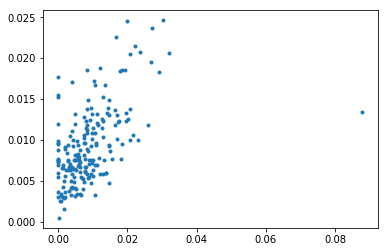

In [265]:
#Plot predictions vs actual
plt.plot(training_set["2017-2018"], prediction["2017-2018"], '.')
print('R^2 : ', r2_score(training_set["2017-2018"], prediction["2017-2018"]))
#x axis is action, y is predicted

### Find out which machine learning model did Darwin use:

In [266]:
status, model_type = ds.lookup_model_name(model)
print(model_type['description']['best_genome'])

[{'layer 1': {'type': 'LinearGene', 'parameters': {'activation': 'relu', 'numunits': 2}}}, {'layer 2': {'type': 'LinearGene', 'parameters': {'activation': 'hardtanh', 'numunits': 58}}}, {'layer 3': {'type': 'LinearGene', 'parameters': {'activation': 'leakyrelu', 'numunits': 1}}}]


Perform model prediction on a test dataset that wasn't used in training. 
Upload test dataset

In [267]:
#Use the remaining 20% of dataset as test set to evaluate model
test_set = labeled_df.iloc[:start, :]
test_set.to_csv('test_data.csv', index=False)
test_set.head()

,County,2017-2018,Median Age,% Age 17 and Under,% High School Graduate or Higher,% Bachelor s Degree or Higher,Unemployment Rate (%),Ethnicity: % Hispanic,Race: % White Alone,Race: % African American Alone,Race: % Asian Alone,Total County Tax Rate,Percent Urban,Per Capita Income,Population Density Per Sq Mile,% Age 18-65
0,Anderson,0.0075,39.1,19.58,80.2,11.8,3.6,17.82,75.11,21.49,0.90,0.590892,32.94,33362.0,55.01,65.88
1,Andrews,0.0107,31.8,30.90,73.8,10.6,3.1,56.19,94.22,1.94,0.75,0.600700,83.50,43105.0,9.85,58.57
2,Angelina,0.0067,37.1,25.81,79.9,15.7,5.1,22.18,81.27,15.44,1.17,0.458800,56.92,37555.0,108.77,58.40
3,Aransas,0.0149,49.3,18.73,83.2,20.2,6.8,27.66,93.05,1.79,1.93,0.403315,72.74,44820.0,91.87,53.97
4,Archer,0.0081,44.3,21.77,90.1,21.8,3.4,8.68,95.58,1.03,0.43,0.675030,11.01,47110.0,10.03,58.34


In [269]:
status, dataset = ds.upload_dataset(os.path.join("./", "test_data.csv"))
if not status:
    print(dataset)

In [270]:
# Clean test dataset
target = "2017-2018"
status, job_id = ds.clean_data("test_data.csv", target = target, model_name = model)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-20T19:44:41.153452', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test_data.csv'], 'artifact_names': ['a1c34abb310f423c97bc1bfc014bae36'], 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-20T19:44:41.153452', 'endtime': '2019-04-20T19:44:42.53663', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test_data.csv'], 'artifact_names': ['a1c34abb310f423c97bc1bfc014bae36'], 'model_name': None, 'job_error': ''}


In [271]:
status, artifact = ds.run_model("test_data.csv", model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Complete', 'starttime': '2019-04-20T19:45:06.495751', 'endtime': '2019-04-20T19:45:07.293297', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.3387911915779114, 'generations': 8, 'dataset_names': ['test_data.csv'], 'artifact_names': ['7869d70824104007affb5ba6ef51a86e'], 'model_name': 'Labels_model8_20190420165230', 'job_error': ''}


(True, 'Job completed')

In [272]:
status, prediction = ds.download_artifact(artifact['artifact_name'])
prediction.head()

,2017-2018
0,0.007787
1,0.008724
2,0.006418
3,0.006054
4,0.015113


R^2 :  0.37680730607791324


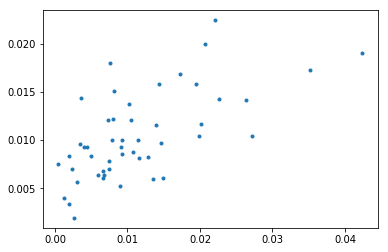

In [273]:
#Plot predictions vs actual
plt.plot(test_set["2017-2018"], prediction["2017-2018"], '.')
print('R^2 : ', r2_score(test_set["2017-2018"], prediction["2017-2018"]))

In [274]:
status, model_type = ds.lookup_model_name(model)
print(model_type['description']['best_genome'])

[{'layer 1': {'type': 'LinearGene', 'parameters': {'activation': 'relu', 'numunits': 2}}}, {'layer 2': {'type': 'LinearGene', 'parameters': {'activation': 'hardtanh', 'numunits': 58}}}, {'layer 3': {'type': 'LinearGene', 'parameters': {'activation': 'leakyrelu', 'numunits': 1}}}]
